In [28]:
import pandas as pd
import numpy as np
from collections import defaultdict
from autoviml.Auto_ViML import Auto_ViML
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn.metrics import balanced_accuracy_score,mean_squared_error
from pprint import pprint
import seaborn as sb
import featuretools as ft
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn import model_selection
import pickle
import scipy
import statistics as stats
## Lasso search
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pickle
sb.set_style('darkgrid')

## Gentic search
from genetic_selection import GeneticSelectionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.linear_model import SGDClassifier
### Hyperopt imports
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK

### optuna imports
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
import os

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,cross_val_predict
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score

import warnings
warnings.filterwarnings(action = 'ignore')

In [29]:
data = pd.read_csv('Parkinsson disease.csv')

In [30]:
print(data.shape)
data.head()

(195, 24)


,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.99,157.30,75.00,0.01,0.00,0.00,0.01,0.01,0.04,0.43,0.02,0.03,0.03,0.07,0.02,21.03,1,0.41,0.82,-4.81,0.27,2.30,0.28
1,phon_R01_S01_2,122.40,148.65,113.82,0.01,0.00,0.00,0.01,0.01,0.06,0.63,0.03,0.05,0.04,0.09,0.02,19.09,1,0.46,0.82,-4.08,0.34,2.49,0.37
2,phon_R01_S01_3,116.68,131.11,111.56,0.01,0.00,0.01,0.01,0.02,0.05,0.48,0.03,0.04,0.04,0.08,0.01,20.65,1,0.43,0.83,-4.44,0.31,2.34,0.33
3,phon_R01_S01_4,116.68,137.87,111.37,0.01,0.00,0.01,0.01,0.02,0.05,0.52,0.03,0.04,0.04,0.09,0.01,20.64,1,0.43,0.82,-4.12,0.33,2.41,0.37
4,phon_R01_S01_5,116.01,141.78,110.66,0.01,0.00,0.01,0.01,0.02,0.06,0.58,0.03,0.05,0.04,0.10,0.02,19.65,1,0.42,0.82,-3.75,0.23,2.33,0.41


In [31]:
data.rename(columns=({'MDVP:Fo(Hz)':'avg_fre', 'MDVP:Fhi(Hz)':'max_fre', 'MDVP:Flo(Hz)':'min_fre', 'MDVP:Jitter(%)':'var_fre1',
       'MDVP:Jitter(Abs)':'var_fre2', 'MDVP:RAP':'var_fre3', 'MDVP:PPQ':'var_fre4', 'Jitter:DDP':'var_fre5',
       'MDVP:Shimmer':'var_amp1', 'MDVP:Shimmer(dB)':'var_amp2', 'Shimmer:APQ3':'var_amp3', 'Shimmer:APQ5':'var_amp4',
       'MDVP:APQ':'var_amp5', 'Shimmer:DDA':'var_amp6'}),inplace=True)
data.head()

,name,avg_fre,max_fre,min_fre,var_fre1,var_fre2,var_fre3,var_fre4,var_fre5,var_amp1,var_amp2,var_amp3,var_amp4,var_amp5,var_amp6,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.99,157.30,75.00,0.01,0.00,0.00,0.01,0.01,0.04,0.43,0.02,0.03,0.03,0.07,0.02,21.03,1,0.41,0.82,-4.81,0.27,2.30,0.28
1,phon_R01_S01_2,122.40,148.65,113.82,0.01,0.00,0.00,0.01,0.01,0.06,0.63,0.03,0.05,0.04,0.09,0.02,19.09,1,0.46,0.82,-4.08,0.34,2.49,0.37
2,phon_R01_S01_3,116.68,131.11,111.56,0.01,0.00,0.01,0.01,0.02,0.05,0.48,0.03,0.04,0.04,0.08,0.01,20.65,1,0.43,0.83,-4.44,0.31,2.34,0.33
3,phon_R01_S01_4,116.68,137.87,111.37,0.01,0.00,0.01,0.01,0.02,0.05,0.52,0.03,0.04,0.04,0.09,0.01,20.64,1,0.43,0.82,-4.12,0.33,2.41,0.37
4,phon_R01_S01_5,116.01,141.78,110.66,0.01,0.00,0.01,0.01,0.02,0.06,0.58,0.03,0.05,0.04,0.10,0.02,19.65,1,0.42,0.82,-3.75,0.23,2.33,0.41


In [32]:
# Dropping Name Column
data.drop('name',1,inplace = True)
print(data.shape)
data.head()

(195, 23)


,avg_fre,max_fre,min_fre,var_fre1,var_fre2,var_fre3,var_fre4,var_fre5,var_amp1,var_amp2,var_amp3,var_amp4,var_amp5,var_amp6,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,119.99,157.30,75.00,0.01,0.00,0.00,0.01,0.01,0.04,0.43,0.02,0.03,0.03,0.07,0.02,21.03,1,0.41,0.82,-4.81,0.27,2.30,0.28
1,122.40,148.65,113.82,0.01,0.00,0.00,0.01,0.01,0.06,0.63,0.03,0.05,0.04,0.09,0.02,19.09,1,0.46,0.82,-4.08,0.34,2.49,0.37
2,116.68,131.11,111.56,0.01,0.00,0.01,0.01,0.02,0.05,0.48,0.03,0.04,0.04,0.08,0.01,20.65,1,0.43,0.83,-4.44,0.31,2.34,0.33
3,116.68,137.87,111.37,0.01,0.00,0.01,0.01,0.02,0.05,0.52,0.03,0.04,0.04,0.09,0.01,20.64,1,0.43,0.82,-4.12,0.33,2.41,0.37
4,116.01,141.78,110.66,0.01,0.00,0.01,0.01,0.02,0.06,0.58,0.03,0.05,0.04,0.10,0.02,19.65,1,0.42,0.82,-3.75,0.23,2.33,0.41


In [33]:
target = 'status'
feats = [x for x in list(data) if x not in target]

In [34]:
feature_matrix = data[feats+[target]]
train_set = feature_matrix.iloc[:135,:]
test_set  = feature_matrix.iloc[135:,:]
print(train_set.shape, test_set.shape)

(135, 23) (60, 23)


In [35]:
feature_matrix.drop('status',axis=1,inplace=True)

In [36]:
### Baseline accuracy is the minimum accuracy that models need to hit ###
test_set[target].mean()

0.6

##############  D A T A   S E T  A N A L Y S I S  #######################
Training Set Shape = (135, 23)
    Training Set Memory Usage = 0.02 MB
Test Set Shape = (60, 23)
    Test Set Memory Usage = 0.01 MB
Single_Label Target: ['status']

################ Binary_Classification VISUALIZATION Started #####################
Random shuffling the data set before training
    Using RandomizedSearchCV for Hyper Parameter Tuning. This is 3X faster than GridSearchCV...
       Class  -> Counts -> Percent
           0:      24  ->   17.8%
           1:     111  ->   82.2%
    Target status is already numeric. No transformation done.
Alert! Rare Class is not 1 but 0 in this data set
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
Classifying variables in data set...
    Number of Numer

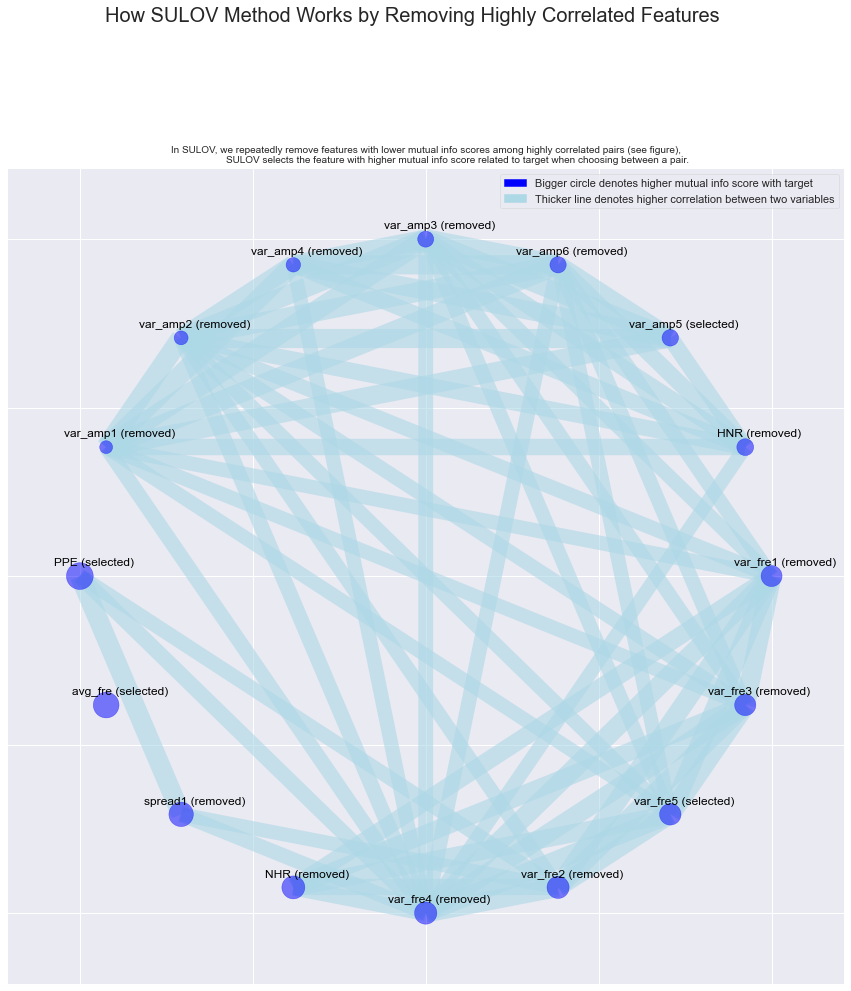

Splitting selected features into float and categorical (integer) variables:
    (10) float variables ...
    (0) categorical vars...
###############################################################################
#######     F E A T U R E   S E L E C T I O N    BY   X G B O O S T    ########
###############################################################################
Current number of predictors = 10 
    Finding Important Features using Boosted Trees algorithm...
        using 10 variables...
        using 8 variables...
        using 6 variables...
        using 4 variables...
        using 2 variables...
Found 10 important features
    Performing limited feature engineering for binning, add_poly and KMeans_Featurizer flags  ...
    Train CV Split completed with TRAIN rows =  121 , CV rows =  14
    Binning_Flag set to False or there are no float vars in data set to be binned
    KMeans_Featurizer set to False or there are no float variables in data
Skipping MinMax scaling since p

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.011663
0:	learn: 0.9586777	test: 0.5714286	best: 0.5714286 (0)	total: 58.5ms	remaining: 2m 55s


500:	learn: 1.0000000	test: 0.7857143	best: 0.9285714 (1)	total: 843ms	remaining: 4.21s
1000:	learn: 1.0000000	test: 0.7857143	best: 0.9285714 (1)	total: 1.79s	remaining: 3.57s
1500:	learn: 1.0000000	test: 0.7857143	best: 0.9285714 (1)	total: 2.6s	remaining: 2.6s
2000:	learn: 1.0000000	test: 0.7857143	best: 0.9285714 (1)	total: 3.62s	remaining: 1.8s
Stopped by overfitting detector  (2000 iterations wait)

bestTest = 0.9285714286
bestIteration = 1

Shrink model to first 2 iterations.
    Actual training time (in seconds): 4
###########  Single_Label  M O D E L   R E S U L T S #################
5-fold Cross Validation logloss = 0.9285714285714286
    CatBoost Best Parameters for Model: Iterations = 1, learning_rate = 0.01
Finding Best Threshold for Highest F1 Score...


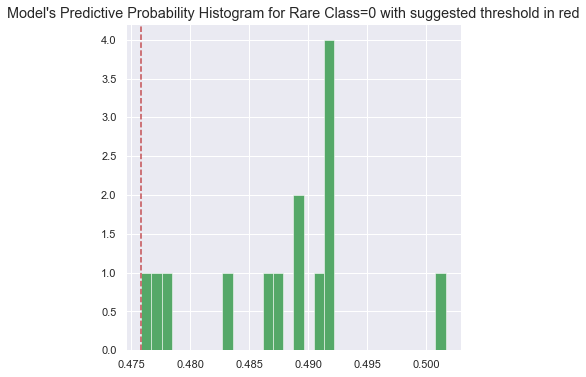

    Using threshold=0.5. However, 0.476 provides better F1=0.92 for rare class...
########################################################
CatBoost Model Prediction Results on Held Out CV Data Set:
    Regular Accuracy Score = 14.3%
Balanced Accuracy = 75.00% with Threshold = 0.50
Confusion Matrix:
[[ 1  1]
 [ 0 12]]
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.92      1.00      0.96        12

    accuracy                           0.93        14
   macro avg       0.96      0.75      0.81        14
weighted avg       0.93      0.93      0.92        14

Balanced Accuracy = 50.00% with Threshold = 0.48
Confusion Matrix:
[[ 2  0]
 [12  0]]
              precision    recall  f1-score   support

           0       0.14      1.00      0.25         2
           1       0.00      0.00      0.00        12

    accuracy                           0.14        14
   macro avg       0.07      0.50      0.12       

After multiple models, Ensemble Model Results:
Binary Class Model Metrics Report
#####################################################
    Accuracy          = 14.3%
    Balanced Accuracy = 50.0%
    Precision         = 0.0%
    Average Precision = 7.1%
    Recall            = 0.0%
    F1 Score          = 0.0%
#####################################################
              precision    recall  f1-score   support

           0       0.14      1.00      0.25         2
           1       0.00      0.00      0.00        12

    accuracy                           0.14        14
   macro avg       0.07      0.50      0.12        14
weighted avg       0.02      0.14      0.04        14

[[ 2  0]
 [12  0]]
#############################################################################
Single Model is better than Ensembling Models for this data set.


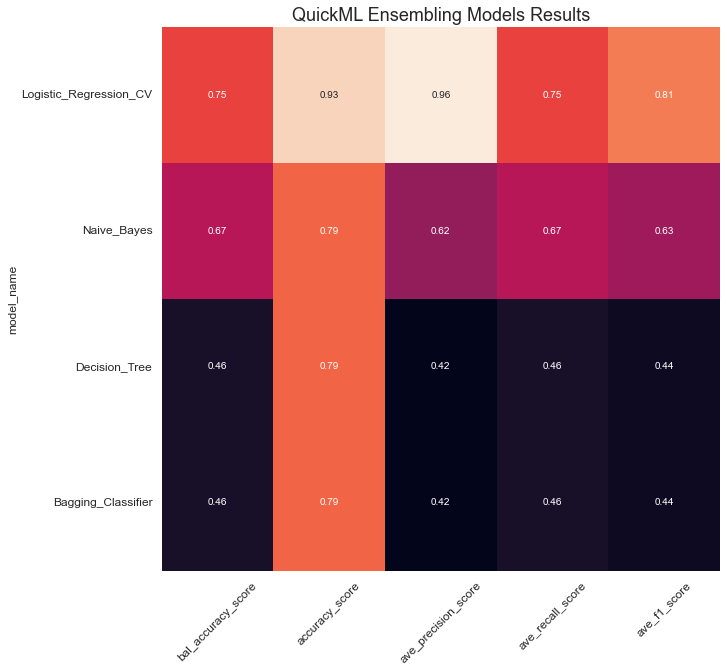

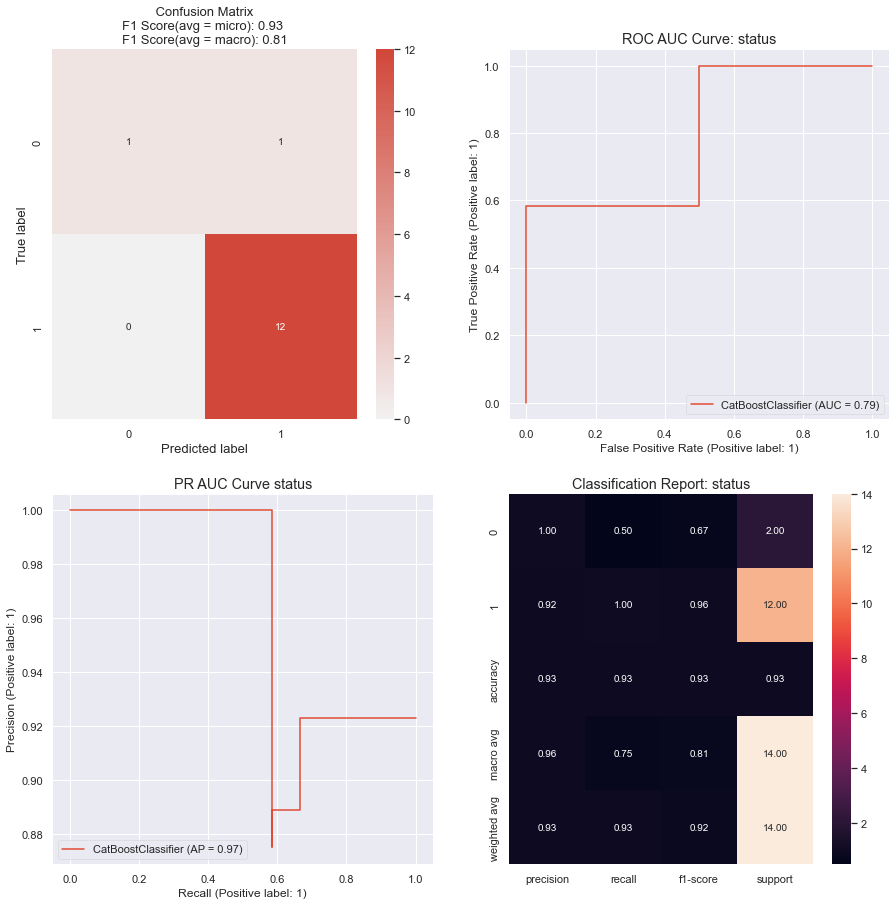

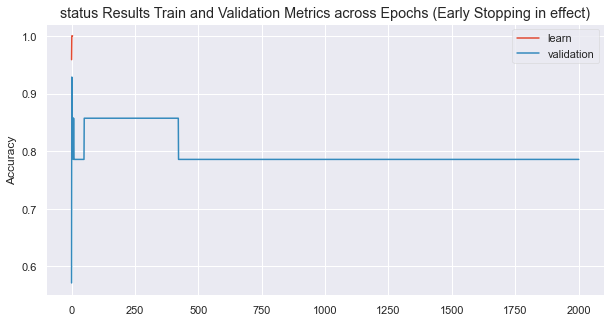

    Time taken for this Target (in seconds) = 12
    Binning_Flag set to False or there are no float vars in data set to be binned
    Setting best params for CatBoost model from Initial State since you cannot change params to a fitted Catboost model 
    Number of Categorical and Integer variables used in CatBoost training = 0
No MinMax scaling performed since scaling flag is set to false
###########################################################################
#####   F I N A L I Z I N G   M O D E L   O N    F U L L   T R A I N  #####
###########################################################################
0:	learn: 0.9333333	total: 1.55ms	remaining: 0us
     Actual Training time taken in seconds = 0
Training of models completed. Now starting predictions on test data...
    Making test Data predictions using regular Threshold = 0.500
    Calculating weighted average ensemble of 5 classifiers
    Plotting Feature Importances to explain the output of model
############### P R E D 

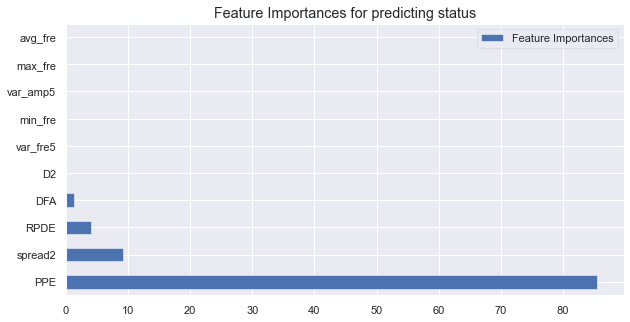

In [37]:
m, feats, trainm, testm = Auto_ViML(train_set, target, test_set,
                            sample_submission='',
                            scoring_parameter='', KMeans_Featurizer=False,
                            hyper_param='RS',feature_reduction=True,
                             Boosting_Flag='CatBoost', Binning_Flag=False,
                            Add_Poly=0, Stacking_Flag=False,Imbalanced_Flag=False,
                            verbose=1)

In [38]:
y_pred = testm[target+'_predictions']
y_pred.mean()

0.6833333333333333

In [39]:
def model_performance(model,x_train,x_test,
                      y_train,y_test):
    print(f"{model} Performance:\n")
    y_train_pred = cross_val_predict(model,x_train,y_train,cv=4)
    plt.figure(figsize = (10,10))
    sb.heatmap(confusion_matrix(y_train,y_train_pred),annot = True)
    plt.title('Confusion Matrix')
    plt.show()
    print('Precision Score:',precision_score(y_train,y_train_pred))
    print("Recall Score:",recall_score(y_train,y_train_pred))
    print("Accuracy Score:",accuracy_score(y_train,y_train_pred))
    print("Cross Val Score Insample",cross_val_score(model,x_train,y_train,cv=4,scoring='accuracy').mean())
    print("Cross Val Score Outsample",cross_val_score(model,x_test,y_test,cv=4,scoring='accuracy').mean())

In [40]:
print(feature_matrix)

     avg_fre  max_fre  min_fre  var_fre1  var_fre2  var_fre3  var_fre4  \
0     119.99   157.30    75.00      0.01      0.00      0.00      0.01   
1     122.40   148.65   113.82      0.01      0.00      0.00      0.01   
2     116.68   131.11   111.56      0.01      0.00      0.01      0.01   
3     116.68   137.87   111.37      0.01      0.00      0.01      0.01   
4     116.01   141.78   110.66      0.01      0.00      0.01      0.01   
..       ...      ...      ...       ...       ...       ...       ...   
190   174.19   230.98    94.26      0.00      0.00      0.00      0.00   
191   209.52   253.02    89.49      0.01      0.00      0.00      0.00   
192   174.69   240.00    74.29      0.01      0.00      0.01      0.01   
193   198.76   396.96    74.90      0.01      0.00      0.00      0.00   
194   214.29   260.28    77.97      0.01      0.00      0.00      0.00   

     var_fre5  var_amp1  var_amp2  var_amp3  var_amp4  var_amp5  var_amp6  \
0        0.01      0.04      0.43 

In [41]:
target = data['status']
feats = [x for x in list(data) if x not in target]

In [45]:
feature_matrix

,avg_fre,max_fre,min_fre,var_fre1,var_fre2,var_fre3,var_fre4,var_fre5,var_amp1,var_amp2,var_amp3,var_amp4,var_amp5,var_amp6,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
0,119.99,157.30,75.00,0.01,0.00,0.00,0.01,0.01,0.04,0.43,0.02,0.03,0.03,0.07,0.02,21.03,0.41,0.82,-4.81,0.27,2.30,0.28
1,122.40,148.65,113.82,0.01,0.00,0.00,0.01,0.01,0.06,0.63,0.03,0.05,0.04,0.09,0.02,19.09,0.46,0.82,-4.08,0.34,2.49,0.37
2,116.68,131.11,111.56,0.01,0.00,0.01,0.01,0.02,0.05,0.48,0.03,0.04,0.04,0.08,0.01,20.65,0.43,0.83,-4.44,0.31,2.34,0.33
3,116.68,137.87,111.37,0.01,0.00,0.01,0.01,0.02,0.05,0.52,0.03,0.04,0.04,0.09,0.01,20.64,0.43,0.82,-4.12,0.33,2.41,0.37
4,116.01,141.78,110.66,0.01,0.00,0.01,0.01,0.02,0.06,0.58,0.03,0.05,0.04,0.10,0.02,19.65,0.42,0.82,-3.75,0.23,2.33,0.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,174.19,230.98,94.26,0.00,0.00,0.00,0.00,0.01,0.04,0.41,0.02,0.02,0.03,0.07,0.03,19.52,0.45,0.66,-6.54,0.12,2.66,0.13
191,209.52,253.02,89.49,0.01,0.00,0.00,0.00,0.01,0.03,0.26,0.02,0.02,0.02,0.05,0.02,19.15,0.43,0.68,-6.20,0.13,2.78,0.17
192,174.69,240.00,74.29,0.01,0.00,0.01,0.01,0.02,0.02,0.26,0.01,0.01,0.02,0.04,0.11,17.88,0.41,0.66,-6.79,0.16,2.68,0.13
193,198.76,396.96,74.90,0.01,0.00,0.00,0.00,0.01,0.02,0.24,0.01,0.01,0.02,0.04,0.07,19.02,0.45,0.64,-6.74,0.21,2.14,0.12


In [46]:
target

0      1
1      1
2      1
3      1
4      1
      ..
190    0
191    0
192    0
193    0
194    0
Name: status, Length: 195, dtype: int64

In [42]:
from sklearn.svm import SVC
svm = SVC(C=1,kernel='linear',gamma='scale')
svm.fit(feature_matrix,target)

SVC(C=1, kernel='linear')

In [47]:
import joblib
joblib.dump(svm,'Predict Parkinson.model')

['Predict Parkinson.model']

In [49]:
svm=joblib.load('Predict Parkinson.model')
feture=[[198.76, 396.96,74.90,0.01,0.00,0.00,0.00,0.01,0.02,0.24,0.01,0.01,0.02,0.04,0.07,19.02,0.45,0.64,-6.74,0.21,2.14,0.12]]
svm.predict(feture)

array([0], dtype=int64)